# LSTNet 

## Modeling Long- and Short-Term Temporal Patterns with Deep Neural Networks
Guokun Lai et al.

https://doi.org/10.1145/3209978.3210006

GitHub of the authors: https://github.com/laiguokun/LSTNet

In [70]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F

print(torch.__version__)
print(f'Is MPS (Metal Performance Shader) even available? {torch.backends.mps.is_available()}')
print(f'Was the current version of PyTorch built with MPS activated? {torch.backends.mps.is_built()}')

mps_device = torch.device("mps")

import random
SEED = 42
random.seed = SEED
np.random.seed(SEED)
_ = torch.manual_seed(SEED)
torch.mps.manual_seed(SEED)

2.2.0.dev20231010
Is MPS (Metal Performance Shader) even available? True
Was the current version of PyTorch built with MPS activated? True


In [71]:
file_name = "data/electricity/electricity.txt"

train_ratio = 0.6
valid_ratio = 0.2
test_ratio = 1 - train_ratio - valid_ratio 

horizon = 24
window = 24 * 7

In [72]:
# Import the Electricity dataset
# - it contains hourly electircity consumption of 321 clients, from 2012 to 2014. 

fin = open(file = file_name)
data_raw = np.loadtxt(fin,delimiter=',')
n, m = data_raw.shape
n, m

(26304, 321)

In [73]:
# Normalize by the maximum value of each column (client)

scale = np.ones(m)
data = np.zeros(data_raw.shape)
for i in range(m):
    scale[i] = np.max(np.abs(data_raw[:,i]))
    data[:,i] = data_raw[:,i] / scale[i]

In [122]:
# Build train, valid and test set on a rolling windows

class Data(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
        self.len = self.X.shape[0]
       
    def __getitem__(self, index):
        return (self.X[index,:], self.Y[index])
            
    def __len__(self):
        return self.len

train_idx = range(window+horizon-1, int(train_ratio * n))
valid_idx = range(int(train_ratio * n), int((train_ratio + valid_ratio) * n))
test_idx = range(int((train_ratio + valid_ratio) * n), n)

def lag(idx):
    l = len(idx)
    X = torch.zeros((l, window, m))
    Y = torch.zeros((l,m))

    for i in range(l):
        end = idx[i] - horizon + 1
        start = end - window
        X[i,:,:] = torch.from_numpy(data[start:end, :])
        Y[i,:] = torch.from_numpy(data[idx[i], :])

    return Data(X,Y)

BATCH_SIZE = 128
train_dataloader = DataLoader(dataset=lag(idx = train_idx), batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = DataLoader(dataset=lag(idx = valid_idx), batch_size=BATCH_SIZE)
test_dataloader  = DataLoader(dataset=lag(idx = test_idx), batch_size=1)

In [131]:
# Define the model

class LSTNet(nn.Module):
    def __init__(self, window, m, conv_kernels=100, kernel_height=7, rnn_hidden_size=40, skip_steps=[], skip_rnn_hidden_size=4, hw=24, droput=0.2):
        super(LSTNet, self).__init__()
        self.window = window
        self.m = m

        self.dropout = nn.Dropout(p = droput)

        # 1. Convolutional layer
        self.conv_kernels = conv_kernels
        self.kernel_size = (kernel_height, m)
        # 
        # input is (N, Cin, H, W), 
        # output is (N, Cout, Hout, Wout)
        self.conv_layer = nn.Conv2d(
            in_channels = 1, 
            out_channels = self.conv_kernels, 
            kernel_size = self.kernel_size)

        # 2. Recurrent layer
        self.rnn_hidden_size = rnn_hidden_size
        #
        # input is (N, L, Hin)       --> Inputs: input, h_0 (defaults to zeros if not provided)
        # output is (N, L, D * Hout) --> Outputs: output, h_n (final hidden state for the input sequence)
        # TODO RELU function as the hidden update activation function
        self.rnn = nn.GRU(
            input_size = self.conv_kernels,
            hidden_size = self.rnn_hidden_size,
            batch_first = True
        )

        # 3. Skip Recurrent layer
        self.skip_steps = skip_steps
        self.skip_rnn_hidden_size = skip_rnn_hidden_size
        self.skip_rnn = {}
        for i in range(len(self.skip_steps)):
            self.skip_rnn[i] = nn.GRU(self.conv_kernels, self.skip_rnn_hidden_size, batch_first=True)

        # 4. Dense layer
        self.union = nn.Linear(
            in_features = self.rnn_hidden_size + np.sum(self.skip_steps)*self.skip_rnn_hidden_size, 
            out_features = m
        )

        # 5. Autoregressive layer
        self.hw = hw
        self.highway = nn.Linear(self.hw, 1)


    def forward(self, x):
        N = x.size(0)

        # 1. Convolutional layer
        c = x.view(N, 1, self.window, self.m)
        c = self.conv_layer(c)
        c = F.relu(c)
        c = self.dropout(c)
        c = torch.squeeze(c, 3)
        c = F.pad(c, (self.kernel_size[0] - 1, 0), value=0)

        # 2. Recurrent layer
        r = c.permute(0,2,1).contiguous()
        out_rnn, _ = self.rnn(r)
        r = out_rnn[:, -1, :]        # (out_rnn[:, -1, :] == hidden_rnn[0])
        r = self.dropout(r)

        # 3. Skip Recurrent layer
        # TODO use Attention!
        for skip_step, skip_rnn in zip(self.skip_steps, self.skip_rnn.values()):
            skipL = c.size(2) // skip_step
            s = c[:, :, -skipL * skip_step:]
            s = s.view(s.size(0), s.size(1), skipL, skip_step)
            s = s.permute(0, 3, 2, 1).contiguous()
            s = s.view(s.size(0) * s.size(1), s.size(2), s.size(3)) 
            h0 = torch.zeros(1, s.size(0), self.skip_rnn_hidden_size, device=s.device)
            out_skip_rnn, _ = skip_rnn(s, h0)
            s = out_skip_rnn[:, -1, :]
            s = s.view(N, skip_step * s.size(1)) 
            s = self.dropout(s)
            r = torch.cat((r,s), 1)

        # 4. Dense layer
        out = self.union(r)

        # 5. Autoregressive layer
        z = x[:, -self.hw:, :]
        z = z.permute(0,2,1).contiguous().view(-1, self.hw)
        z = self.highway(z)
        z = self.dropout(z)
        z = z.view(-1,self.m)
        out = out + z

        return out

In [132]:
# Instantiate the model, the loss and the optimizer

model = LSTNet(
    window,
    m,
    conv_kernels=100,
    kernel_height=6,
    rnn_hidden_size=40,
    skip_steps=[24],
    skip_rnn_hidden_size=4,
    hw=24,
    droput=0.3
)#.to(mps_device)
print(model)

learning_rate = 0.001

loss_fn = nn.MSELoss(reduction='sum')
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

LSTNet(
  (dropout): Dropout(p=0.3, inplace=False)
  (conv_layer): Conv2d(1, 100, kernel_size=(6, 321), stride=(1, 1))
  (rnn): GRU(100, 40, batch_first=True)
  (union): Linear(in_features=136, out_features=321, bias=True)
  (highway): Linear(in_features=24, out_features=1, bias=True)
)


In [133]:
# Training loop

num_epochs = 1000

best_val_loss = np.inf
best_model = None
PATIENCE = 20
min_delta = 0.0001
current_patience = 0

history = {
     'train_loss': [],
     'val_loss': []
}

for epoch in range(num_epochs):

    train_loss = 0.0
    model.train()
    for x, y, in train_dataloader:
        optimizer.zero_grad()
        out = model(x)
        loss = loss_fn(out, y)
        loss.backward()        
        optimizer.step()
        train_loss += loss.item() / x.size(0) / m
    history['train_loss'].append(train_loss / len(train_dataloader))

    val_loss = 0.0
    model.eval()
    with torch.no_grad():
        for x, y, in valid_dataloader:
            out = model(x)
            loss += loss_fn(out, y).item()
            val_loss += loss / x.size(0) / m
    history['val_loss'].append(val_loss / len(valid_dataloader))

    print(f'Epoch {epoch+1} \t Train Loss: {(train_loss / len(train_dataloader)):.3f} \t Val Loss: {(val_loss / len(valid_dataloader)):.3f}')

    # Early stopping
    if val_loss < best_val_loss - min_delta:
            best_val_loss = val_loss
            best_model = model.state_dict()
            print(f"Early stopping, new validation best: {(best_val_loss / len(valid_dataloader)):.3f}, keep training!")
            current_patience = 0
    else:
        current_patience += 1
        
    if current_patience >= PATIENCE:
        print(f"Early stopping after {epoch+1} epochs. Validation best: {(best_val_loss / len(valid_dataloader)):.3f}")
        break

Epoch 1 	 Train Loss: 0.078 	 Val Loss: 1.110
Early stopping, new validation best: 1.110, keep training!
Epoch 2 	 Train Loss: 0.026 	 Val Loss: 0.426
Early stopping, new validation best: 0.426, keep training!
Epoch 3 	 Train Loss: 0.018 	 Val Loss: 0.375
Early stopping, new validation best: 0.375, keep training!
Epoch 4 	 Train Loss: 0.015 	 Val Loss: 0.359
Early stopping, new validation best: 0.359, keep training!
Epoch 5 	 Train Loss: 0.013 	 Val Loss: 0.321
Early stopping, new validation best: 0.321, keep training!
Epoch 6 	 Train Loss: 0.012 	 Val Loss: 0.332
Epoch 7 	 Train Loss: 0.011 	 Val Loss: 0.323
Epoch 8 	 Train Loss: 0.010 	 Val Loss: 0.281
Early stopping, new validation best: 0.281, keep training!
Epoch 9 	 Train Loss: 0.009 	 Val Loss: 0.316
Epoch 10 	 Train Loss: 0.009 	 Val Loss: 0.312
Epoch 11 	 Train Loss: 0.009 	 Val Loss: 0.307
Epoch 12 	 Train Loss: 0.008 	 Val Loss: 0.279
Early stopping, new validation best: 0.279, keep training!
Epoch 13 	 Train Loss: 0.008 	 V

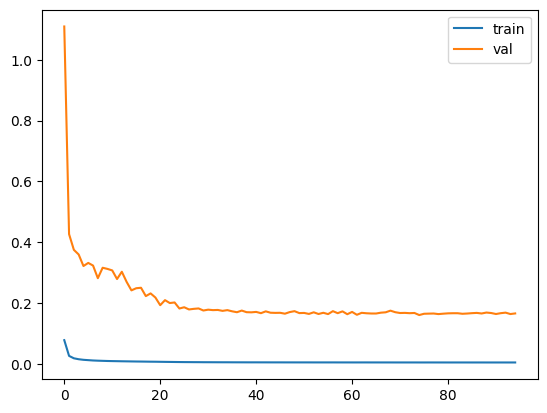

In [134]:
plt.plot(history['train_loss'], label='train')
plt.plot(history['val_loss'], label='val')
plt.legend()
plt.show()

In [145]:
# Load the best model state into the model
model.load_state_dict(best_model)

torch.save(model.state_dict(), "./models/LSTNet.model")

In [146]:
# Inference

yhat = np.empty(shape=(len(test_dataloader), m))
actual = np.empty(shape=(len(test_dataloader), m))
model.eval()
with torch.no_grad():
    for i, (x, y) in tqdm(enumerate(test_dataloader), total=len(test_dataloader)):
        yhat[i,:] = model(x).numpy().reshape(-1)
        actual[i,:] = y.numpy().reshape(-1)

100%|██████████| 5261/5261 [00:12<00:00, 434.68it/s]


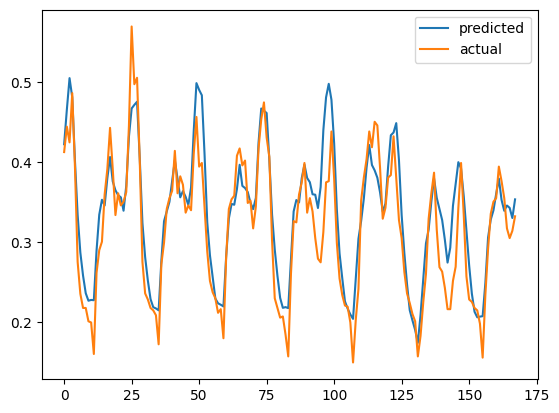

In [147]:
# Forecast plot

S = 5

plt.plot(yhat[:24*7,S], label="predicted")
plt.plot(actual[:24*7,S], label="actual")
plt.legend()